## Model Prediction

In [1]:
from ultralytics import YOLO
import numpy as np
import cv2
import sys
import torch
from PIL import Image
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor
import matplotlib.pyplot as plt
import os

In [2]:
os.chdir('../')

In [3]:
%pwd

'/home/utpal108/dev/Upwork/Projects/Image-Segmentation-Model-Using-YOLOv8-and-SAM'

In [4]:
def yolov8_detection(model, image_path):

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = model(image, stream=True)  # generator of Results objects

    for result in results:
        boxes = result.boxes  # Boxes object for bbox outputs
    
    bbox = boxes.xyxy.tolist()
    bbox = [[int(i) for i in box] for box in bbox]
    return bbox, image

In [5]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2)) 

In [6]:
image = cv2.imread('artifacts/images/input.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
model=YOLO('artifacts/model/best.pt')

In [7]:
image_path = 'artifacts/images/input.jpg'
yolov8_boxex, image = yolov8_detection(model, image_path)


0: 640x640 72 RBCs, 1 WBC, 848.5ms
Speed: 2.3ms preprocess, 848.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


In [8]:
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cpu"

In [9]:
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [10]:
predictor = SamPredictor(sam)
predictor.set_image(image)
input_boxes = torch.tensor(yolov8_boxex, device=predictor.device)

In [11]:
transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

Bounding box: [549, 314, 43, 57]
yolo [    0.85781     0.49062     0.92344     0.57812     0.88281     0.49062     0.88125     0.49219     0.87969     0.49219     0.87656     0.49531       0.875     0.49531     0.86562     0.50469     0.86562     0.50625     0.86406     0.50781     0.86406     0.50938      0.8625     0.51094      0.8625      0.5125
     0.86094     0.51406     0.86094     0.51719     0.85938     0.51875     0.85938       0.525     0.85781     0.52656     0.85781     0.54219     0.85938     0.54375     0.85938        0.55     0.86094     0.55156     0.86094     0.55312      0.8625     0.55469      0.8625     0.55781     0.86406     0.55937
     0.86406     0.56094     0.86719     0.56406     0.86719     0.56563     0.87656       0.575     0.87969       0.575     0.88125     0.57656     0.88438     0.57656     0.88594     0.57812     0.89531     0.57812     0.89687     0.57656         0.9     0.57656     0.90156       0.575     0.90312       0.575
     0.90469     0.5734

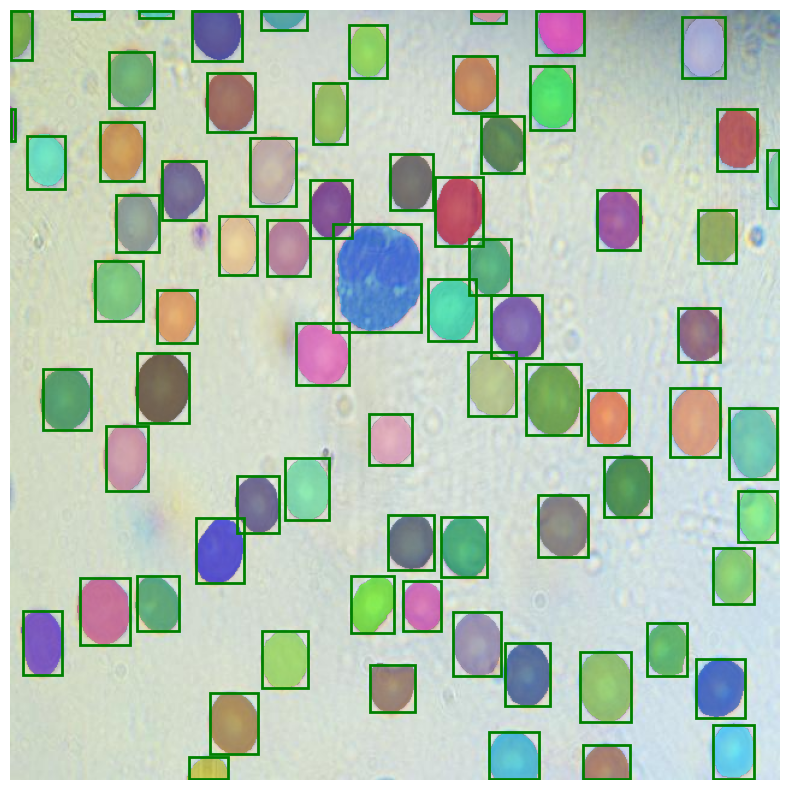

True

In [12]:
for i, mask in enumerate(masks):

    binary_mask = masks[i].squeeze().numpy().astype(np.uint8)

    # Find the contours of the mask
    contours, hierarchy = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    largest_contour = max(contours, key=cv2.contourArea)

    # Get the new bounding box
    bbox = [int(x) for x in cv2.boundingRect(largest_contour)]

    # Get the segmentation mask for object 
    segmentation = largest_contour.flatten().tolist()

    # Write bounding boxes to file in YOLO format
    with open('BBOX_yolo.txt', 'w') as f:
        for contour in contours:
            # Get the bounding box coordinates of the contour
            x, y, w, h = cv2.boundingRect(contour)
            # Convert the coordinates to YOLO format and write to file
            f.write('0 {:.6f} {:.6f} {:.6f} {:.6f}\n'.format((x+w/2)/image.shape[1], (y+h/2)/image.shape[0], w/image.shape[1], h/image.shape[0]))
            f.write('\n')
    mask=segmentation
    
        # load the image
    #width, height = image_path.size
    img = Image.open(image_path)
    width, height = img.size

    # convert mask to numpy array of shape (N,2)
    mask = np.array(mask).reshape(-1,2)

    # normalize the pixel coordinates
    mask_norm = mask / np.array([width, height])

    # compute the bounding box
    xmin, ymin = mask_norm.min(axis=0)
    xmax, ymax = mask_norm.max(axis=0)
    bbox_norm = np.array([xmin, ymin, xmax, ymax])

    # concatenate bbox and mask to obtain YOLO format
    yolo = np.concatenate([bbox_norm, mask_norm.reshape(-1)])

    # compute the bounding box
    # write the yolo values to a text file
    with open('yolomask_format.txt', 'w') as f:
        for val in yolo:
            f.write("{:.6f} ".format(val))
        f.write('\n')

    # Print the bounding box and segmentation mask
    print("Bounding box:", bbox)
    #print("Segmentation mask:", segmentation)
    print("yolo",yolo)
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box.cpu().numpy(), plt.gca())
plt.axis('off')
plt.savefig('artifacts/images/output_02.png')
plt.show()
cv2.imwrite("output_maskimg.jpg", image)

In [14]:
image2 = cv2.imread("artifacts/images/input.jpg")
h, w = image2.shape[:2]
with open("yolomask_format.txt") as f:
    segment = [np.array(x.split(), dtype=np.float32).reshape(-1, 2) for x in f.read().strip().splitlines() if len(x)]
for s in segment:
    s[:, 0] *= w
    s[:, 1] *= h
cv2.drawContours(image2, [s.astype(np.int32) for s in segment], -1, (0, 0, 255))
cv2.imwrite("output_maskimg.jpg", image2)

True